# Customer churn in banking


**An aim of the research** — build machine learning models:
1. Pre-processing to handle imbalanced data
2. Definition of optimal hyper-parameters
3. Comparison of models built in PyTorch and Scikit-learn frameworks
4. Measurement of the models performance on testing data
5. Checking the models using various metrics


**An initial data**

The dataframe is extracted from `Churn.csv` file. Due to data cleaning has already been done on the dataset only handling imbalanced data is required to carry out the analysis.
 
The research is divided into seven steps:
  1. Data overview
  2. Transformation of dataset for training
  3. Model training on imbalanced data
  4. Handling imbalanced data
  5. In-depth analysis using PyTorch
  6. In-depth analysis using Scikit-learn
  7. Model testing

### Step 1. Data overview

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder    
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import shuffle 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs

In [ ]:
# set two decimal places
pd.set_option('precision', 2)

In [ ]:
# read 'Churn.csv' and print out 10 rows
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:  
    df = pd.read_csv('C:/YandexPracticumProjects/Project_7_BankingSystem_ML/Churn.csv')

df.loc[0:9].style

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.00,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.00,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.00,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.00,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.00,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.00,134603.88,1,1,1,71725.73,0


In [ ]:
# shape of initial data
df.shape

(10000, 14)

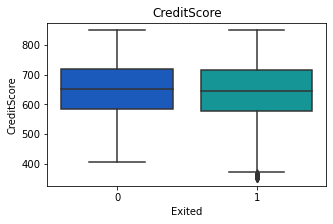

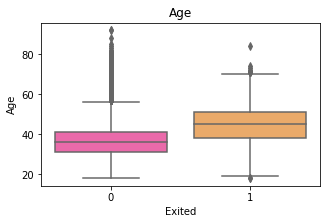

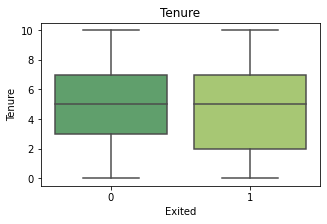

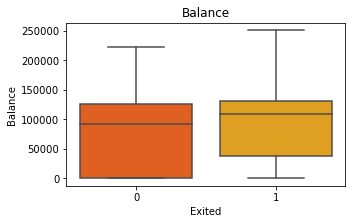

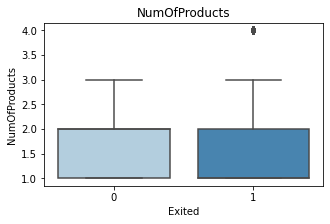

In [ ]:
# variables to iterate over
features_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts']
palette_list = ['winter', 'spring', 'summer', 'autumn', 'Blues']

# vizualization of features
for feat, pal in zip(features_list, palette_list):
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='Exited', y=feat, data=df, palette=pal).set_title(feat);

In [ ]:
# unique values in 'Geography'
print(df['Geography'].unique())

['France' 'Spain' 'Germany']


In [ ]:
# unique values in 'Gender'
print(df['Gender'].unique())

['Female' 'Male']


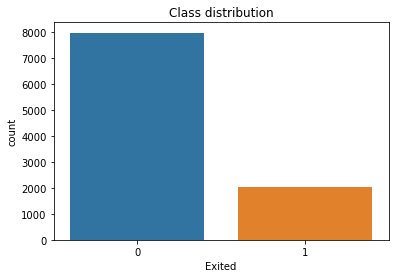

In [ ]:
# class distribution
sns.countplot(x ='Exited', data=df).set_title('Class distribution');

In [ ]:
# check for NaN values
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

As seen on the bar chart, there is an imbalance of classes in the data: the ratio of "0" and "1" classes is approximately 4/1.

### Step 2. Transformation of dataset for training

In [ ]:
# fill in NaN values with average
df['Tenure'].fillna(value=0, inplace=True)

In [ ]:
# integer encode of 'Gender' using Label Encoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Gender'])

# binary encode of 'Gender' using One-Hot Encoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
df['Gender'] = onehot_encoder.fit_transform(integer_encoded)

In [ ]:
# categirical encode of 'Geography' using Dummy Encoder
dummies = pd.get_dummies(df[['Geography']], drop_first=False)
df = pd.concat([df.drop(['Geography'], axis=1), dummies], axis=1)

In [ ]:
# shape of encoded data
df.shape

(10000, 16)

In [ ]:
# print out 10 rows of encoded data
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,1.0,42,2.0,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,1.0,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,1.0,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,1.0,39,1.0,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,1.0,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1
5,6,15574012,Chu,645,0.0,44,8.0,113755.78,2,1,0,149756.71,1,0,0,1
6,7,15592531,Bartlett,822,0.0,50,7.0,0.00,2,1,1,10062.80,0,1,0,0
7,8,15656148,Obinna,376,1.0,29,4.0,115046.74,4,1,0,119346.88,1,0,1,0
8,9,15792365,He,501,0.0,44,4.0,142051.07,2,0,1,74940.50,0,1,0,0
9,10,15592389,H?,684,0.0,27,2.0,134603.88,1,1,1,71725.73,0,1,0,0


In [ ]:
# multivariate analysis
def mult_anal(data):    
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(data.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

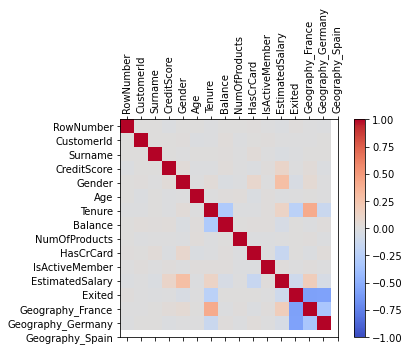

In [ ]:
# heatmap of dataframe
mult_anal(df)

In [ ]:
# create features and target
X = df.drop(['Exited', 'Surname', 'RowNumber', 'CustomerId'], axis=1)
y = df['Exited']

# seed the RNG
torch.manual_seed(777)

# convert data to pytorch tensors
X = torch.tensor(X.values)
y = torch.tensor(y.values)

In [ ]:
# ckeck for NaN values
np.nan_to_num(X, 0)
np.isnan(X).sum()

tensor(0)

In [ ]:
# set aside 40% of train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, 
    test_size=0.4, random_state=777, stratify=y)

# use the same function above for the test set
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
    test_size=0.5, random_state=777, stratify=y_val)  

In [ ]:
# print out datasets for ML
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: torch.Size([6000, 12])
y_train shape: torch.Size([6000])
X_val shape: torch.Size([2000, 12])
y val shape: torch.Size([2000])
X_test shape: torch.Size([2000, 12])
y_test shape: torch.Size([2000])


In [ ]:
# scaler function
scaler = StandardScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train))
X_val = torch.tensor(scaler.transform(X_val))
X_test = torch.tensor(scaler.transform(X_test))
next(iter(X_train))

tensor([-1.5327, -0.9220,  1.0542, -0.5056, -1.2215,  0.8009,  0.6489, -1.0374,
        -1.5188, -1.0027, -0.5761,  1.7344], dtype=torch.float64)

There is a good correlation, close to zero in average.

Also, missing values in the Tenure column are filled in with the average values.

In addition, data is scaled for further analysis.

### Step 3. Model training on imbalanced data with PyTorch

In [ ]:
# set hyper-parameters
epochs = 500+1
print_epoch = 100
learning_rate = 0.001
batch_size = 64
input_dim = 12
output_dim = 1

# interface with TensorBoard
writer = SummaryWriter()

In [ ]:
# define dataset class
class Data(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len    

In [ ]:
# create data for training and validation
train_data_imbalanced = Data(X_train, y_train)
val_data_imbalanced = Data(X_val, y_val)

# dataloaders
train_loader_imbalanced = DataLoader(
    dataset=train_data_imbalanced, 
    batch_size=batch_size,
    num_workers=0, 
    shuffle=True, 
    pin_memory=False, 
    drop_last=True
)

val_loader_imbalanced = DataLoader(
    dataset=val_data_imbalanced, 
    batch_size=batch_size,  
    num_workers=0, 
    shuffle=True, 
    pin_memory=False
)

In [ ]:
# Logistic Regression
Image(url='https://media5.datahacker.rs/2021/01/83-1024x579.jpg', 
      width=550, height=300
)

In [ ]:
# define the network
class LogRegPytorch(nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogRegPytorch, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs  

In [ ]:
# model, loss, optimizer
pytorch_model = LogRegPytorch(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)    

In [ ]:
# calculate accuracy
def accuracy(y_pred, y):
    return torch.sum((y_pred >= 0.5).reshape(1, -1) == y).item() / y.shape[0]

In [ ]:
# train the model
def learning(train_loader, val_loader):
    
    val_result = [] 
    for epoch in range(epochs):
        
        iteration_loss = 0
        iteration_accuracy = 0
        
        # model training
        pytorch_model.train()
        for i, data in enumerate(train_loader):
            X, y = data
            y_pred = pytorch_model(X.float())
            loss = criterion(y_pred, y.reshape(-1, 1).float())     
        
            iteration_loss += loss
            iteration_accuracy += accuracy(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        if(epoch % print_epoch == 0):
            print('Train: epoch: {0} | loss: {1:.5f} | acc: {2:.3f}'.format(
                epoch, iteration_loss / (i + 1), iteration_accuracy / (i + 1)
                ))    

        iteration_loss = 0
        iteration_accuracy = 0    

        # model validation
        pytorch_model.eval()
        for i, data in enumerate(val_loader):
            X, y = data
            y_pred = pytorch_model(X.float())
            loss = criterion(y_pred, y.reshape(-1, 1).float())

            iteration_loss += loss
            iteration_accuracy += accuracy(y_pred, y)

            # record losses for each epoch
            writer.add_scalars(
                main_tag='loss', 
                tag_scalar_dict={'validation': loss},
                global_step=epoch)

            if(epoch == epochs - 1):
                val_result.append((y, ((y_pred >= 0.5) + 0).reshape(1, -1)[0]))

        if(epoch % print_epoch == 0):
            print('Valid: epoch: {0} | loss: {1:.5f} | acc: {2:.3f}'.format(
                epoch, iteration_loss / (i + 1), iteration_accuracy / (i + 1)
                ))  

    # close the writer
    writer.close()
    
    return val_result                  

In [ ]:
# using imbalanced data
val_result_imbalanced = learning(train_loader_imbalanced, val_loader_imbalanced)

Train: epoch: 0 | loss: 0.65560 | acc: 0.627
Valid: epoch: 0 | loss: 0.64268 | acc: 0.644
Train: epoch: 100 | loss: 0.44116 | acc: 0.811
Valid: epoch: 100 | loss: 0.44292 | acc: 0.812
Train: epoch: 200 | loss: 0.42811 | acc: 0.812
Valid: epoch: 200 | loss: 0.43053 | acc: 0.812
Train: epoch: 300 | loss: 0.42574 | acc: 0.812
Valid: epoch: 300 | loss: 0.43006 | acc: 0.811
Train: epoch: 400 | loss: 0.42498 | acc: 0.812
Valid: epoch: 400 | loss: 0.42816 | acc: 0.813
Train: epoch: 500 | loss: 0.42497 | acc: 0.811
Valid: epoch: 500 | loss: 0.43364 | acc: 0.807


In [ ]:
# ground truth values are in 1st list and predictions are in 2nd list
true, pred_pytorch = zip(*val_result_imbalanced)
true, pred_pytorch = torch.cat(true), torch.cat(pred_pytorch)

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    print('class 0 accuracy: {0:.3f}'.format(cm[0, 0] / sum(cm[0])))
    print('class 1 accuracy: {0:.3f}'.format(cm[1, 1] / sum(cm[1])))
    disp.plot();

class 0 accuracy: 0.958
class 1 accuracy: 0.231


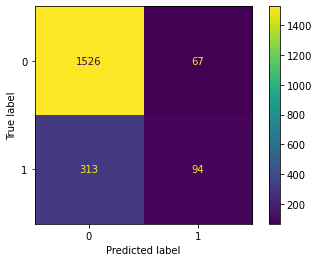

In [ ]:
# plot confusion matrix for imbalanced data
plot_confusion_matrix(true, pred_pytorch)

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(true, pred_pytorch))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.58      0.23      0.33       407

    accuracy                           0.81      2000
   macro avg       0.71      0.59      0.61      2000
weighted avg       0.78      0.81      0.78      2000



Validation of the model without handling the imbalance shows that a high accuracy of class "0" predictions (0.958) and a low one for class "1" (0.231) are achieved. This ratio is also confirmed by the F1-score metric and unbalanced Precision and Recall indicators.

### Step 4. Handling imbalanced data

In [ ]:
# classes 
neg = torch.sum(y_train == 0)
pos = torch.sum(y_train == 1)
counts = {'0': neg.item(), '1': pos.item()}
print(counts)

{'0': 4778, '1': 1222}


In [ ]:
# upsampling function
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_up = torch.cat([X_zeros] + [X_ones] * repeat)
    y_up = torch.cat([y_zeros] + [y_ones] * repeat)
    
    X_up, y_up = shuffle(X_up, y_up, random_state=777)
    
    return X_up, y_up

In [ ]:
# upsampling for train, valid and test dataset
X_train, y_train = upsample(X_train, y_train, 4)
X_val, y_val = upsample(X_val, y_val, 4)
X_test, y_test = upsample(X_test, y_test, 4)
print('upsample class 0: {0:.0f}'.format(torch.sum(y_train == 0).item()))
print('upsample class 1: {0:.0f}'.format(torch.sum(y_train == 1).item()))

upsample class 0: 4778
upsample class 1: 4888


In [ ]:
# oversampling function
def oversample(X, y):  
    diff = sum(y == 1) - sum(y == 0)
    indices = torch.where(y == 0)[0]
    rand_subsample = torch.randint(0, len(indices), (diff,))
    X_over, y_over = torch.cat((X, X[indices[rand_subsample]])),\
                     torch.cat((y, y[indices[rand_subsample]]))
    return X_over, y_over       

In [ ]:
# oversampling for class 1
X_train, y_train = oversample(X_train, y_train) 
X_val, y_val = oversample(X_val, y_val)
X_test, y_test = oversample(X_test, y_test)
print('oversample class 0: {0:.0f}'.format(torch.sum(y_train == 0).item()))
print('oversample class 1: {0:.0f}'.format(torch.sum(y_train == 1).item()))

oversample class 0: 4888
oversample class 1: 4888


In [ ]:
# weighted sampler
def calcWeights(data, n_classes):                        
    
    count = [0] * n_classes                                                      
    for item in data:                                                         
        count[item[1].int()] += 1                                                     
    
    weight_per_class = [0] * n_classes                                      
    N = float(sum(count))                                                   
    for i in range(n_classes):                                                   
        weight_per_class[i] = N / float(count[i])                                 
    
    weight = [0] * len(data)                                              
    for idx, val in enumerate(data):                                          
        weight[idx] = weight_per_class[val[1].int()]                                  
    
    return weight         

In [ ]:
# calculate weights for training data
weights_train = calcWeights(X_train, 2)
weights_train = torch.DoubleTensor(weights_train)
print('training weights:', weights_train)

sampler_train = torch.utils.data.sampler.WeightedRandomSampler(
    weights_train, len(X_train), replacement=True
)  

training weights: tensor([2.0240, 2.0240, 1.9765,  ..., 1.9765, 2.0240, 1.9765],
       dtype=torch.float64)


In [ ]:
# calculate weights for validation data
weights_val = calcWeights(X_val, 2)
weights_val = torch.DoubleTensor(weights_val)
print('validation weights:', weights_val)

sampler_val = torch.utils.data.sampler.WeightedRandomSampler(
    weights_val, len(X_val), replacement=True
)  

validation weights: tensor([2.0062, 1.9939, 2.0062,  ..., 2.0062, 1.9939, 2.0062],
       dtype=torch.float64)


In [ ]:
# calculate weights for testing data
weights_test = calcWeights(X_test, 2)
weights_test = torch.DoubleTensor(weights_test)
print('testing weights:', weights_test)

sampler_test = torch.utils.data.sampler.WeightedRandomSampler(
    weights_test, len(X_test), replacement=True
)  

testing weights: tensor([1.9359, 2.0684, 2.0684,  ..., 2.0684, 1.9359, 1.9359],
       dtype=torch.float64)


In [ ]:
# normalization of train, valid and test data
X_train = F.normalize(X_train, p=2.0, dim=1)
X_val = F.normalize(X_val, p=2.0, dim=1)
X_test = F.normalize(X_test, p=2.0, dim=1)
X = F.normalize(X, p=2.0, dim=1)
next(iter(X_train))

tensor([-0.0142,  0.3534, -0.3118, -0.4762,  0.1126,  0.2610,  0.2115, -0.3380,
         0.3673,  0.3250, -0.1877, -0.1879], dtype=torch.float64)

Several methods have been applied to handle the imbalanced data. At the beginning, Upsampling is used for approximate adjustment of data by classes. Then, the Oversampling function for class "1" is used for exact equality of classes.

Additionally, the weights for the Sampler are calculated, therefore, a uniform amount of data by class is loaded through the Dataloader for each batch.

### Step 5. In-depth analysis using PyTorch 

In [ ]:
# create data for testing and validation
train_data_balanced = Data(X_train, y_train)
val_data_balanced = Data(X_val, y_val)

# dataloaders with sampler
train_loader_balanced = DataLoader(
    dataset=train_data_balanced, 
    batch_size=batch_size, 
    sampler=sampler_train,
    num_workers=0, 
    shuffle=False, 
    pin_memory=False, 
    drop_last=True
)

val_loader_balanced = DataLoader(
    dataset=val_data_balanced, 
    batch_size=batch_size, 
    sampler=sampler_val, 
    num_workers=0, 
    shuffle=False, 
    pin_memory=False
)    

In [ ]:
# train the model using balanced data
val_result_balanced = learning(train_loader_balanced, val_loader_balanced)

Train: epoch: 0 | loss: 0.88469 | acc: 0.509
Valid: epoch: 0 | loss: 0.86788 | acc: 0.517
Train: epoch: 100 | loss: 0.59997 | acc: 0.705
Valid: epoch: 100 | loss: 0.60379 | acc: 0.694
Train: epoch: 200 | loss: 0.58369 | acc: 0.719
Valid: epoch: 200 | loss: 0.58610 | acc: 0.697
Train: epoch: 300 | loss: 0.58249 | acc: 0.705
Valid: epoch: 300 | loss: 0.59203 | acc: 0.685
Train: epoch: 400 | loss: 0.57450 | acc: 0.708
Valid: epoch: 400 | loss: 0.59752 | acc: 0.672
Train: epoch: 500 | loss: 0.57027 | acc: 0.715
Valid: epoch: 500 | loss: 0.58128 | acc: 0.695


In [ ]:
# ground truth values are in 1st list and predictions are in 2nd list
true, pred_pytorch = zip(*val_result_balanced)
true, pred_pytorch = torch.cat(true), torch.cat(pred_pytorch)

class 0 accuracy: 0.711
class 1 accuracy: 0.678


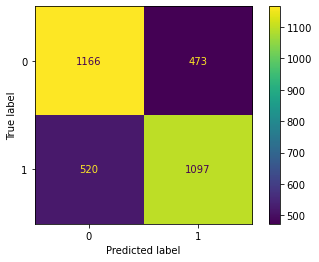

In [ ]:
# plot confusion matrix for balanced data
plot_confusion_matrix(true, pred_pytorch)

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(true, pred_pytorch))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1639
           1       0.70      0.68      0.69      1617

    accuracy                           0.70      3256
   macro avg       0.70      0.69      0.69      3256
weighted avg       0.70      0.70      0.69      3256



After balancing the data, the same model is trained, built in PyTorch based on a simple neural network simulating the Logistic Regression.

As a result, a sufficiently high accuracy of predictions is achieved for class "0" (0.711) and for class "1" (0.678). This ratio is also confirmed by the F1-score metric of 0.71 and 0.69 for classes "0" and "1", respectively.

### Step 6. In-depth analysis using Scikit-learn

In [ ]:
# convert pytorch tensors to numpy arrays
X_train = X_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()
X_val = X_val.detach().cpu().numpy() 
y_val = y_val.detach().cpu().numpy()

In [ ]:
# find optimal hyperparameters for the model
def model_valid_LG():    
    # define dataset
    X_train, y_train = make_blobs(
        n_samples=1000, centers=2, n_features=100, cluster_std=20
    )
    
    # define models and parameters
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    
    # define grid search
    grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=grid, 
        n_jobs=-1,
        cv=cv, 
        scoring='accuracy', 
        error_score=0
    )
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# optimal hyperparameters for the model
model_valid_LG()

Best: 0.962000 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.955000 (0.022023) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.951333 (0.023907) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.956000 (0.018547) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.956333 (0.021053) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.955000 (0.023345) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.956667 (0.018679) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.957000 (0.021158) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.956667 (0.021029) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.957000 (0.019000) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.958667 (0.021561) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.958333 (0.021461) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.957333 (0.018962) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.960333 (0.020734) wi

In [ ]:
# Logistic Regression model
sklearn_model = LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=0.01, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight=None, 
    random_state=777, 
    solver='liblinear', 
    max_iter=500, 
    multi_class='auto', 
    verbose=0, 
    warm_start=False, 
    n_jobs=None, 
    l1_ratio=None
)

# train the model
sklearn_model.fit(X_train, y_train)
# make predictions 
pred_sklearn = sklearn_model.predict(X_val) 

In [ ]:
# plot receiver operating characteristic
def roc_plot(model, y, X, lable, title):
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=lable % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()    

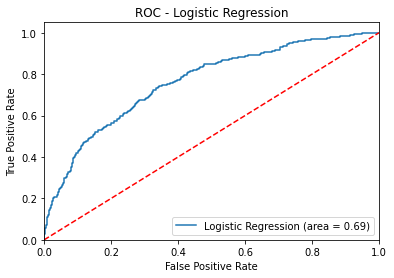

In [ ]:
# ROC curve - Logistic Regression 
roc_plot(sklearn_model, y_val, X_val, 'Logistic Regression (area = %0.2f)', 
        'ROC - Logistic Regression')

In [ ]:
# print out relationship between Threshold, Precision and Recall
prob_valid = sklearn_model.predict_proba(X_val)
prob_one_valid = prob_valid[:, 1]

for threshold in np.arange(0.2, 0.6, 0.02):
    pred_valid = prob_one_valid > threshold
    precision = precision_score(y_val, pred_valid)
    recall = recall_score(y_val, pred_valid)

    print('Threshold: {:.2f} | Precision: {:.3f}, Recall: {:.3f}'.format(
        threshold, precision, recall))

Threshold: 0.20 | Precision: 0.508, Recall: 0.998
Threshold: 0.22 | Precision: 0.516, Recall: 0.995
Threshold: 0.24 | Precision: 0.521, Recall: 0.985
Threshold: 0.26 | Precision: 0.528, Recall: 0.980
Threshold: 0.28 | Precision: 0.540, Recall: 0.971
Threshold: 0.30 | Precision: 0.553, Recall: 0.963
Threshold: 0.32 | Precision: 0.564, Recall: 0.948
Threshold: 0.34 | Precision: 0.570, Recall: 0.912
Threshold: 0.36 | Precision: 0.583, Recall: 0.894
Threshold: 0.38 | Precision: 0.604, Recall: 0.880
Threshold: 0.40 | Precision: 0.620, Recall: 0.862
Threshold: 0.42 | Precision: 0.638, Recall: 0.838
Threshold: 0.44 | Precision: 0.652, Recall: 0.808
Threshold: 0.46 | Precision: 0.664, Recall: 0.759
Threshold: 0.48 | Precision: 0.686, Recall: 0.730
Threshold: 0.50 | Precision: 0.700, Recall: 0.673
Threshold: 0.52 | Precision: 0.712, Recall: 0.619
Threshold: 0.54 | Precision: 0.725, Recall: 0.582
Threshold: 0.56 | Precision: 0.748, Recall: 0.550
Threshold: 0.58 | Precision: 0.773, Recall: 0.514


In [ ]:
# plot Precision-Recall vs Threshold chart
def threshold_chart():    
    precision, recall, thresholds = precision_recall_curve(y_val, prob_valid[:, 1]) 
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall vs Threshold Chart')
    plt.plot(thresholds, precision[: -1], 'b--', label='Precision')
    plt.plot(thresholds, recall[: -1], 'r--', label='Recall')
    plt.ylabel('Precision, Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([0, 1]);

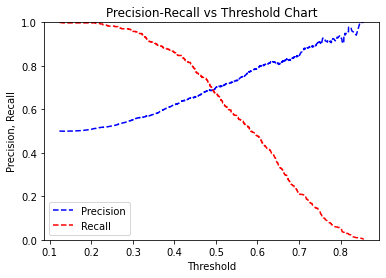

In [ ]:
# threshold chart
threshold_chart()

In [ ]:
# find an optimal threshold
threshold = []
accuracy_bal = []
for p in np.unique(sklearn_model.predict_proba(X_train)[:, 1]):
    threshold.append(p)
    y_pred = (sklearn_model.predict_proba(X_train)[:, 1] >= p).astype(int)
    accuracy_bal.append(balanced_accuracy_score(y_train, y_pred)) 

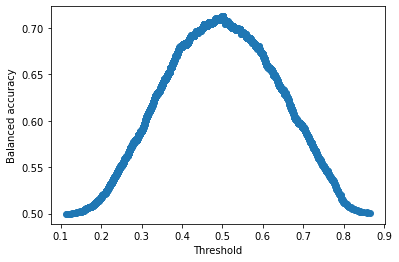

In [ ]:
# plot balanced accuracy
plt.scatter(threshold, accuracy_bal)
plt.xlabel('Threshold')
plt.ylabel('Balanced accuracy')
plt.show()

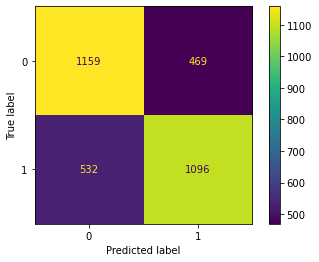

In [ ]:
# print out confusion matrix
cm = confusion_matrix(y_val, pred_sklearn, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot();

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_val, pred_sklearn))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1628
           1       0.70      0.67      0.69      1628

    accuracy                           0.69      3256
   macro avg       0.69      0.69      0.69      3256
weighted avg       0.69      0.69      0.69      3256



For comparison, a model is built using the standard library from Scikit-learn for Logistic Regression.

As a result, a similar accuracy of predictions for classes "0" and "1" equal to 0.7 was achieved, which can be seen on the Balanced accuracy graph.

This ratio is also confirmed by the F1-score metric of 0.69 and 0.68 for classes "0" and "1", respectively.

Also, the balance of the model is characterized by the intersection of the Precision and Recall curves. The probability of each class is 0.5.

### Step 7. Model testing

In [ ]:
# create data for testing
test_data_balanced = Data(X_test, y_test)

# dataloader with sampler
test_loader_balanced = DataLoader(
    dataset=test_data_balanced, batch_size=batch_size, sampler=sampler_test,
    num_workers=0, shuffle=False, pin_memory=False, drop_last=True
)

In [ ]:
# test the model
def testing(test_loader):
    
    test_result = [] 
    for epoch in range(epochs):

        iteration_loss = 0
        iteration_accuracy = 0       
        
        # model validation
        pytorch_model.eval()
        for i, data in enumerate(test_loader):
            X, y = data
            y_pred = pytorch_model(X.float())
            loss = criterion(y_pred, y.reshape(-1, 1).float())

            iteration_loss += loss
            iteration_accuracy += accuracy(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if(epoch == epochs - 1):
                test_result.append((y, ((y_pred >= 0.5) + 0).reshape(1, -1)[0]))

        if(epoch % print_epoch == 0):
            print('Test: epoch: {0} | loss: {1:.5f} | acc: {2:.3f}'.format(
                epoch, iteration_loss / (i + 1), iteration_accuracy / (i + 1)
                ))  

    return test_result   

In [ ]:
# test the model using balanced data
test_result_balanced = testing(test_loader_balanced)

Test: epoch: 0 | loss: 0.58187 | acc: 0.703
Test: epoch: 100 | loss: 0.57828 | acc: 0.706
Test: epoch: 200 | loss: 0.56359 | acc: 0.721
Test: epoch: 300 | loss: 0.58542 | acc: 0.703
Test: epoch: 400 | loss: 0.58235 | acc: 0.706
Test: epoch: 500 | loss: 0.56692 | acc: 0.717


In [ ]:
# ground truth values are in 1st list and predictions are in 2nd list
true, pred_pytorch = zip(*test_result_balanced)
true, pred_pytorch = torch.cat(true), torch.cat(pred_pytorch)

class 0 accuracy: 0.711
class 1 accuracy: 0.722


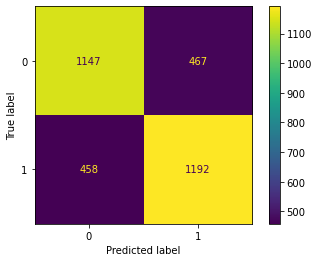

In [ ]:
# plot confusion matrix for balanced data
plot_confusion_matrix(true, pred_pytorch)

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(true, pred_pytorch))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1614
           1       0.72      0.72      0.72      1650

    accuracy                           0.72      3264
   macro avg       0.72      0.72      0.72      3264
weighted avg       0.72      0.72      0.72      3264



Testing the model on the test data shows the high performance of the model and the robustness of the balanced data.

The results are confirmed by the F1-score metric of 0.71 and 0.72 for classes "0" and "1", respectively, as well as the accuracy value of 0.711 for "0" and 0.722 for "1".

### Conclusions

In accordance with statistical data on customer behavior and termination of agreements with the bank, a model is built that uses Logistic Regression to predict the probability of the top event by comparing it with a logistic curve. To do this, the dependent variable "y" is introduced, which is "0" (the event did not occur) and "1" (the event occurred), and the independent variables "X" characterizing the behavior of clients.

To select the parameters of the model, a training data is extracted from the full data consisting of independent variables "X" and the corresponding values ​​of the dependent variable "y".

The main model built using the PyTorch libraries based on a simple neural network consists of a linear regression and a Sigmoid function.

Linear regression converts the point cloud obtained from the independent variables "X" into a straight line, which is characterized by the angle of inclination (weight) and vertical position (bias).

Sigmoid converts the output from linear regression to a probability of outcome from 0 to 1 by updating the gradient descend residual to find the local minimum. A probability above 0.5 (threshold) corresponds to class "1", and below 0.5 to class "0".

Finally, the model demonstrates a high accuracy, the percentage of correct predictions on the test set is around 0.72 for both classes.